In [53]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


from tqdm.auto import tqdm

In [37]:
# считываем данные из файлы
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-allaberganov/Statistics/Lesson_10/hw_aa.csv', sep = ';')
df

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [38]:
# смотрим сколько уникальных значений находятся в каждой колонке
df.nunique()

Unnamed: 0           127018
uid                  127018
experimentVariant         2
version                   4
purchase                  2
dtype: int64

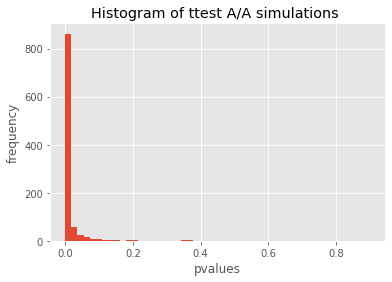

0.934

In [40]:
# проводим A/A тест, чтобы определить есть ли стат.значемые различия
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df['experimentVariant'] == 1]['purchase'].sample(n_s, replace = False).values
    s2 = df[df['experimentVariant'] == 0]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

По результатам теста, мы можем видить, что в 93.4% случиях мы получаем статистически значемые различия. То есть наше значение превышает установленное значение альфы, равное в 0.05.

In [41]:
# смотрим, сколько уникальных версий МП мы имеем
df['version'].unique()

array(['v2.8.0', 'v2.9.0', 'v3.7.4.0', 'v3.8.0.0'], dtype=object)

In [64]:
df.groupby(['experimentVariant', 'version'], as_index = False) \
    .agg({'purchase': 'mean', 'uid': 'count'}) \
    .rename(columns = {'uid': 'number_of_customer'})

,experimentVariant,version,purchase,number_of_customer
0,0,v2.8.0,0.000993,41283
1,0,v2.9.0,0.074658,11921
2,0,v3.7.4.0,0.059943,4204
3,0,v3.8.0.0,0.057604,5694
4,1,v2.8.0,0.045606,41552
5,1,v2.9.0,0.071304,12033
6,1,v3.7.4.0,0.063018,4221
7,1,v3.8.0.0,0.062848,6110


Здесь уже визуально видно, что количество пользователей в эксперементальных группах, и в версии МП разделены более менее одинаково (столбец "number_of_customer"). Однако, уже на данном этапе можно заметить, что в версии МП "v2.8.0" среднее количество покупок очень сильно отличаются, а именно: 0.000993 в группе 0, и 0.045606 в группе 1.

Далее проводим t-test для разных версий МП, и сравниваем эксперементальные группы между собой.

In [57]:
stats.ttest_ind(df[(df['version'] == 'v2.8.0') & (df['experimentVariant'] == 1)]['purchase'], 
                df[(df['version'] == 'v2.8.0') & (df['experimentVariant'] == 0)]['purchase'])

Ttest_indResult(statistic=42.963540840360324, pvalue=0.0)

In [60]:
stats.ttest_ind(df[(df['version'] == 'v2.9.0') & (df['experimentVariant'] == 1)]['purchase'], 
                df[(df['version'] == 'v2.9.0') & (df['experimentVariant'] == 0)]['purchase'])

Ttest_indResult(statistic=-0.9979597634962479, pvalue=0.31830895167207446)

In [61]:
stats.ttest_ind(df[(df['version'] == 'v3.7.4.0') & (df['experimentVariant'] == 1)]['purchase'], 
                df[(df['version'] == 'v3.7.4.0') & (df['experimentVariant'] == 0)]['purchase'])

Ttest_indResult(statistic=0.5874925850487471, pvalue=0.5568886771079735)

In [62]:
stats.ttest_ind(df[(df['version'] == 'v3.8.0.0') & (df['experimentVariant'] == 1)]['purchase'], 
                df[(df['version'] == 'v3.8.0.0') & (df['experimentVariant'] == 0)]['purchase'])

Ttest_indResult(statistic=1.1956188950206779, pvalue=0.23186933664059722)

Также, посредством t-test мы еще раз убедились, что в версии МП 'v2.8.0' имеются значимые различия, так как pvalue < 0.05.

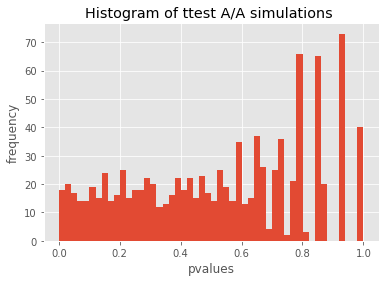

0.046

In [65]:
# проводим A/A тест, исключая из выборки версию МП 'v2.8.0'.
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df['experimentVariant'] == 1) & (df['version'] != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df['experimentVariant'] == 0) & (df['version'] != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

Вот теперь, мы уже получаем результат, где FPR меньше чем 0.05. Таким образом, в системе сплитования наблюдался так называемый "шум" из-за версии МП "v2.8.0", из-за которого возникало стат. значимые различия в наших группах.